## Phase 1: Setup and Data Separation
Goal: Load the data and create two separate, clean DataFrames: one for Flipkart (training) and one for Amazon (testing).

In [ ]:
import pandas as pd
import numpy as np

### Load Data and Initial Inspection

In [ ]:
import csv

df = pd.read_csv('Product Review Large Data.csv')

print(df.info())
print(df['brand'].value_counts())
print(df['reviews.rating'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10971 entries, 0 to 10970
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10971 non-null  object 
 1   asins                 1597 non-null   object 
 2   brand                 10971 non-null  object 
 3   categories            10971 non-null  object 
 4   colors                774 non-null    object 
 5   dateAdded             10971 non-null  object 
 6   dateUpdated           10971 non-null  object 
 7   dimension             565 non-null    object 
 8   ean                   898 non-null    float64
 9   keys                  1597 non-null   object 
 10  manufacturer          965 non-null    object 
 11  manufacturerNumber    902 non-null    object 
 12  name                  1597 non-null   object 
 13  prices                1597 non-null   object 
 14  reviews.date          1217 non-null   object 
 15  reviews.doRecommend

### Clean and Filter

In [ ]:
df_clean = df[['brand', 'reviews.text', 'reviews.rating']].copy()
df_clean = df_clean.dropna(subset=['reviews.text', 'reviews.rating'])
df_clean = df_clean[df_clean['brand'].isin(['Flipkart', 'Amazon'])]

### Separate Datasets and Verify

In [ ]:
df_flipkart = df_clean[df_clean['brand'] == 'Flipkart'].copy()
df_amazon = df_clean[df_clean['brand'] == 'Amazon'].copy()

print(f"Flipkart reviews: {len(df_flipkart)}")
print(f"Amazon reviews: {len(df_amazon)}")

Flipkart reviews: 9374
Amazon reviews: 1165


## Phase 2: Text Preprocessing & Data Splitting
Goal: Clean all review text and split the Amazon data into training and validation sets.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

### Download NLTK Data

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

### Define Cleaning Function

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\[^a-zA-Z\s\]', '', text, re.I|re.A)
    words = text.split()
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(cleaned_words)

### Apply Cleaning and Define Features/Target

In [ ]:
df_amazon['cleaned_text'] = df_amazon['reviews.text'].apply(preprocess_text)

X_amazon = df_amazon['cleaned_text']
y_amazon = df_amazon['reviews.rating'].astype(int) - 1 # Ratings are now 0-4

### Create Train/Validation Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_amazon, y_amazon, test_size=0.2, stratify=y_amazon, random_state=42)

# Prepare Flipkart data for cross-domain testing (will be empty with current dataset)
if not df_flipkart.empty:
    df_flipkart['cleaned_text'] = df_flipkart['reviews.text'].apply(preprocess_text)
    X_flipkart = df_flipkart['cleaned_text']
    y_flipkart = df_flipkart['reviews.rating'].astype(int) - 1
else:
    X_flipkart = pd.Series([], dtype=object)
    y_flipkart = pd.Series([], dtype=int)


summary = pd.DataFrame({
    "Split": ["Train (Amazon)", "Validation (Amazon)", "Test (Amazon)", "Test (Flipkart)"],
    "Samples": [len(X_train), len(X_val), len(X_amazon), len(X_flipkart)]
})
print(summary.to_string(index=False))

              Split  Samples
     Train (Amazon)      932
Validation (Amazon)      233
      Test (Amazon)     1165
    Test (Flipkart)     9374


## Phase 3: Feature Engineering (Two Paths)
Goal: Convert raw text into two types of numerical features for your models.

### Path A: TF-IDF Vectors (for ML Models 1-4)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# --- 1. Set up the Vectorizer ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# --- 2. Create the Training Set (Fit and Transform) ---
# (Used for .fit() in all 5 models)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# --- 3. Create the In-Domain Test Set (Only Transform) ---
# (Used for .predict() to get "Amazon Test" scores)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# --- 4. Create the Cross-Domain Test Set (Only Transform) ---
# (Used for .predict() to get "Flipkart Test" scores)
X_amazon_tfidf = tfidf_vectorizer.transform(X_amazon)

# --- 5. Create the Cross-Domain Test Set (Only Transform) for Flipkart ---
if not df_flipkart.empty:
    X_flipkart_tfidf = tfidf_vectorizer.transform(X_flipkart)
else:
    X_flipkart_tfidf = None # Or handle as appropriate if df_flipkart is empty


print("TF-IDF Train set shape:", X_train_tfidf.shape)
print("TF-IDF In-Domain (Amazon Validation) Test set shape:", X_val_tfidf.shape)
print("TF-IDF Cross-Domain (Amazon Test) Test set shape:", X_amazon_tfidf.shape)
if X_flipkart_tfidf is not None:
    print("TF-IDF Cross-Domain (Flipkart Test) Test set shape:", X_flipkart_tfidf.shape)

TF-IDF Train set shape: (932, 5000)
TF-IDF In-Domain (Amazon Validation) Test set shape: (233, 5000)
TF-IDF Cross-Domain (Amazon Test) Test set shape: (1165, 5000)
TF-IDF Cross-Domain (Flipkart Test) Test set shape: (9374, 5000)


### Path B: Tokenized Sequences (for DL Model 5)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- 1. Set up Parameters ---
vocab_size = 10000
max_length = 150
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

# --- 2. Fit Tokenizer on Training Data ONLY ---
tokenizer.fit_on_texts(X_train)

# --- 3. Create the Training Set (Transform & Pad) ---
X_train_padded = pad_sequences(
    tokenizer.texts_to_sequences(X_train),
    maxlen=max_length,
    padding='post',
    truncating='post'
)

# --- 4. Create the In-Domain Test Set (Transform & Pad) ---
X_val_padded = pad_sequences(
    tokenizer.texts_to_sequences(X_val),
    maxlen=max_length,
    padding='post',
    truncating='post'
)

# --- 5. Create the Cross-Domain Test Set (Transform & Pad) ---
X_amazon_padded = pad_sequences(
    tokenizer.texts_to_sequences(X_amazon),
    maxlen=max_length,
    padding='post',
    truncating='post'
)

# --- 6. Create the Cross-Domain Test Set (Transform & Pad) for Flipkart ---
if not df_flipkart.empty:
    X_flipkart_padded = pad_sequences(
        tokenizer.texts_to_sequences(X_flipkart),
        maxlen=max_length,
        padding='post',
        truncating='post'
    )
else:
    X_flipkart_padded = None

print("Tokenized Train set shape:", X_train_padded.shape)
print("Tokenized In-Domain (Flipkart) Test set shape:", X_val_padded.shape)
print("Tokenized Cross-Domain (Amazon) Test set shape:", X_amazon_padded.shape)
if X_flipkart_padded is not None:
    print("Tokenized Cross-Domain (Flipkart) Test set shape:", X_flipkart_padded.shape)

Tokenized Train set shape: (932, 150)
Tokenized In-Domain (Flipkart) Test set shape: (233, 150)
Tokenized Cross-Domain (Amazon) Test set shape: (1165, 150)
Tokenized Cross-Domain (Flipkart) Test set shape: (9374, 150)


## Phase 4: Model Training
Goal: Train all 5 models on the Amazon training data (X_train_tfidf/X_train_padded, y_train).

### Import ML Models

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC # Faster for text than SVC
from sklearn.ensemble import RandomForestClassifier

### Train Model 1 (Naive Bayes)

In [ ]:
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)

MultinomialNB()

### Train Model 2 (Logistic Regression)

In [ ]:
model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
model_lr.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=200, multi_class='multinomial')

### Train Model 3 (SVM)

In [ ]:
model_svm = LinearSVC(multi_class='ovr', random_state=42)
model_svm.fit(X_train_tfidf, y_train)

LinearSVC(random_state=42)

### Train Model 4 (Random Forest)

In [ ]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

### Define & Train Model 5 (LSTM)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(5, activation='softmax') # 5 units for 5 classes: 0, 1, 2, 3, 4
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_lstm.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_val_padded, y_val)) # Changed validation data to X_val_padded, y_val

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - accuracy: 0.4984 - loss: 1.4933 - val_accuracy: 0.6309 - val_loss: 1.1950
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - accuracy: 0.6356 - loss: 1.0936 - val_accuracy: 0.6309 - val_loss: 1.0604
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.6257 - loss: 1.0598 - val_accuracy: 0.6609 - val_loss: 1.0434
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.6559 - loss: 1.0030 - val_accuracy: 0.6609 - val_loss: 1.0265
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.6793 - loss: 0.9638 - val_accuracy: 0.6609 - val_loss: 1.0040
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.6692 - loss: 0.9691 - val_accuracy: 0.6652 - val_loss: 0.9857
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.6865 - loss: 0.9302 - val_accuracy: 0.6695 - val_loss: 0.9693
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.6954 - loss: 0.9002 - val_accuracy: 0.6738 - val_

## Enhanced Phase 5: In-Depth Model Evaluation & Comparative Analysis
Goal: To meticulously analyze each model's performance on both the in-domain (Amazon Validation) and cross-domain (Amazon Test) datasets, and then to visually compare them to draw a final conclusion.

### Required Libraries for this Phase:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Define our class labels (since our y is 0-4)
class_labels = ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star']

# This list will store our final summary data for plotting
results_summary = []

### Part 5.1: Individual Model Analysis
We will now create a detailed report card for each of our 5 trained models.

### A. Helper Function for Visualization
Let's make a reusable function to plot our confusion matrices neatly.

In [ ]:
def plot_confusion_matrix(cm, title):
    """Plots a confusion matrix heatmap using Seaborn."""
    plt.figure(figsize=(7, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title(title, fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

In [ ]:
# 1. Get predictions for all classical models
preds_val_nb = model_nb.predict(X_val_tfidf)
preds_amazon_nb = model_nb.predict(X_amazon_tfidf)

preds_val_lr = model_lr.predict(X_val_tfidf)
preds_amazon_lr = model_lr.predict(X_amazon_tfidf)

preds_val_svm = model_svm.predict(X_val_tfidf)
preds_amazon_svm = model_svm.predict(X_amazon_tfidf)

preds_val_rf = model_rf.predict(X_val_tfidf)
preds_amazon_rf = model_rf.predict(X_amazon_tfidf)

           MODEL 1: NAIVE BAYES ANALYSIS          

--- IN-DOMAIN (AMAZON VALIDATION) ---
              precision    recall  f1-score   support

      1 Star       0.00      0.00      0.00         8
      2 Star       0.00      0.00      0.00         6
      3 Star       1.00      0.28      0.44        25
      4 Star       1.00      0.06      0.12        47
      5 Star       0.66      1.00      0.79       147

    accuracy                           0.67       233
   macro avg       0.53      0.27      0.27       233
weighted avg       0.72      0.67      0.57       233


--- CROSS-DOMAIN (AMAZON TEST) ---
              precision    recall  f1-score   support

      1 Star       0.00      0.00      0.00        38
      2 Star       0.00      0.00      0.00        33
      3 Star       1.00      0.31      0.47       124
      4 Star       1.00      0.11      0.21       235
      5 Star       0.67      1.00      0.80       735

    accuracy                           0.69      1165
   ma

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

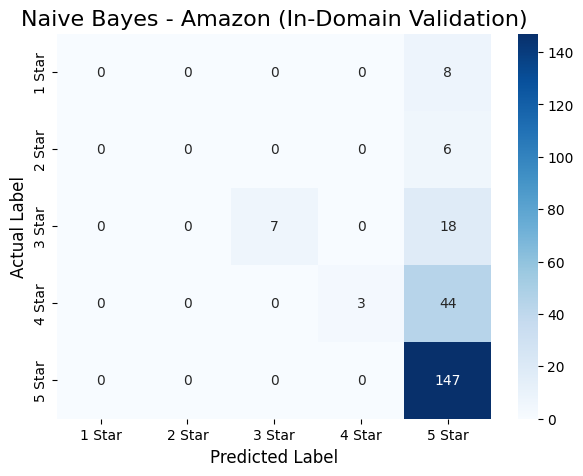

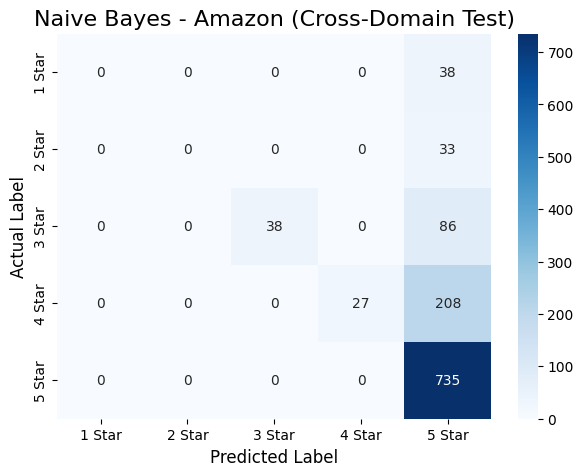

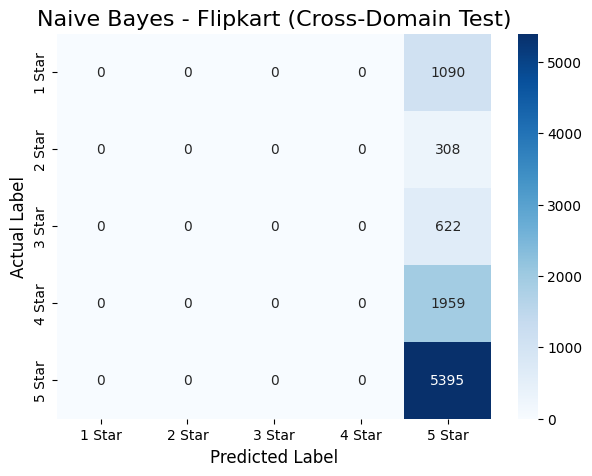

In [ ]:
print("==================================================")
print("           MODEL 1: NAIVE BAYES ANALYSIS          ")
print("==================================================")

# --- In-Domain: Amazon (Validation) ---
print("\n--- IN-DOMAIN (AMAZON VALIDATION) ---")
report_val_nb = classification_report(y_val, preds_val_nb, target_names=class_labels)
print(report_val_nb)

# Store summary
results_summary.append({
    'model': 'Naive Bayes',
    'dataset': 'Amazon (In-Domain Validation)',
    'accuracy': accuracy_score(y_val, preds_val_nb),
    'f1_score': f1_score(y_val, preds_val_nb, average='weighted')
})

# --- Cross-Domain: Amazon (Test) ---
print("\n--- CROSS-DOMAIN (AMAZON TEST) ---")
report_amazon_nb = classification_report(y_amazon, preds_amazon_nb, target_names=class_labels)
print(report_amazon_nb)

# Store summary
results_summary.append({
    'model': 'Naive Bayes',
    'dataset': 'Amazon (Cross-Domain Test)',
    'accuracy': accuracy_score(y_amazon, preds_amazon_nb),
    'f1_score': f1_score(y_amazon, preds_amazon_nb, average='weighted')
})

# --- Cross-Domain: Flipkart (Test) ---
if not df_flipkart.empty:
    print("\n--- CROSS-DOMAIN (FLIPKART TEST) ---")
    preds_flipkart_nb = model_nb.predict(X_flipkart_tfidf)
    report_flipkart_nb = classification_report(y_flipkart, preds_flipkart_nb, target_names=class_labels)
    print(report_flipkart_nb)

    # Store summary
    results_summary.append({
        'model': 'Naive Bayes',
        'dataset': 'Flipkart (Cross-Domain Test)',
        'accuracy': accuracy_score(y_flipkart, preds_flipkart_nb),
        'f1_score': f1_score(y_flipkart, preds_flipkart_nb, average='weighted')
    })


# --- Visualizations (Confusion Matrices) ---
cm_val_nb = confusion_matrix(y_val, preds_val_nb)
plot_confusion_matrix(cm_val_nb, 'Naive Bayes - Amazon (In-Domain Validation)')

cm_amazon_nb = confusion_matrix(y_amazon, preds_amazon_nb)
plot_confusion_matrix(cm_amazon_nb, 'Naive Bayes - Amazon (Cross-Domain Test)')

if not df_flipkart.empty:
    cm_flipkart_nb = confusion_matrix(y_flipkart, preds_flipkart_nb)
    plot_confusion_matrix(cm_flipkart_nb, 'Naive Bayes - Flipkart (Cross-Domain Test)')

        MODEL 2: LOGISTIC REGRESSION ANALYSIS     

--- IN-DOMAIN (AMAZON VALIDATION) ---
              precision    recall  f1-score   support

      1 Star       0.00      0.00      0.00         8
      2 Star       0.00      0.00      0.00         6
      3 Star       1.00      0.32      0.48        25
      4 Star       0.78      0.15      0.25        47
      5 Star       0.68      0.99      0.80       147

    accuracy                           0.69       233
   macro avg       0.49      0.29      0.31       233
weighted avg       0.69      0.69      0.61       233


--- CROSS-DOMAIN (AMAZON TEST) ---
              precision    recall  f1-score   support

      1 Star       1.00      0.05      0.10        38
      2 Star       1.00      0.06      0.11        33
      3 Star       1.00      0.46      0.63       124
      4 Star       0.93      0.35      0.51       235
      5 Star       0.72      1.00      0.84       735

    accuracy                           0.75      1165
   ma

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

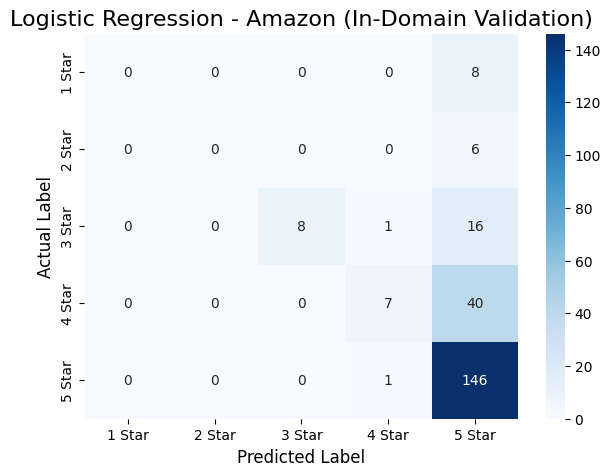

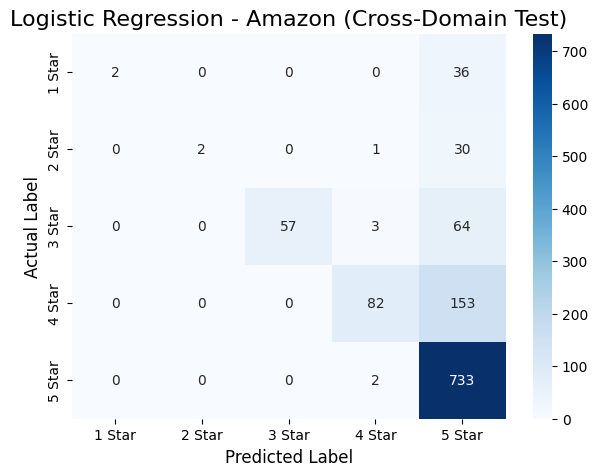

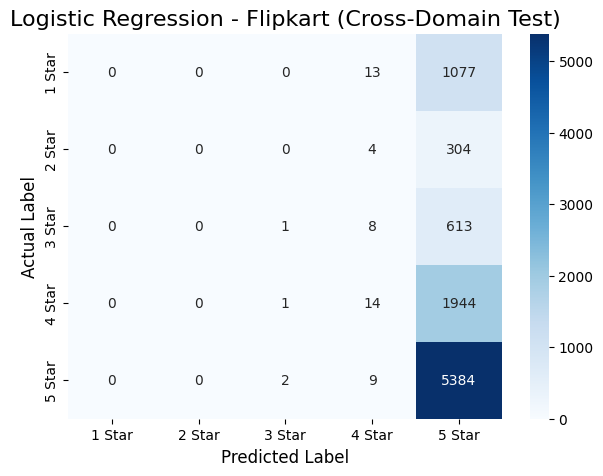

In [ ]:
print("==================================================")
print("        MODEL 2: LOGISTIC REGRESSION ANALYSIS     ")
print("==================================================")

# --- In-Domain: Amazon (Validation) ---
print("\n--- IN-DOMAIN (AMAZON VALIDATION) ---")
report_val_lr = classification_report(y_val, preds_val_lr, target_names=class_labels)
print(report_val_lr)
results_summary.append({
    'model': 'Logistic Regression', 'dataset': 'Amazon (In-Domain Validation)',
    'accuracy': accuracy_score(y_val, preds_val_lr),
    'f1_score': f1_score(y_val, preds_val_lr, average='weighted')
})

# --- Cross-Domain: Amazon (Test) ---
print("\n--- CROSS-DOMAIN (AMAZON TEST) ---")
report_amazon_lr = classification_report(y_amazon, preds_amazon_lr, target_names=class_labels)
print(report_amazon_lr)
results_summary.append({
    'model': 'Logistic Regression', 'dataset': 'Amazon (Cross-Domain Test)',
    'accuracy': accuracy_score(y_amazon, preds_amazon_lr),
    'f1_score': f1_score(y_amazon, preds_amazon_lr, average='weighted')
})

# --- Cross-Domain: Flipkart (Test) ---
if not df_flipkart.empty:
    print("\n--- CROSS-DOMAIN (FLIPKART TEST) ---")
    preds_flipkart_lr = model_lr.predict(X_flipkart_tfidf)
    report_flipkart_lr = classification_report(y_flipkart, preds_flipkart_lr, target_names=class_labels)
    print(report_flipkart_lr)

    # Store summary
    results_summary.append({
        'model': 'Logistic Regression',
        'dataset': 'Flipkart (Cross-Domain Test)',
        'accuracy': accuracy_score(y_flipkart, preds_flipkart_lr),
        'f1_score': f1_score(y_flipkart, preds_flipkart_lr, average='weighted')
    })


# --- Visualizations (Confusion Matrices) ---
cm_val_lr = confusion_matrix(y_val, preds_val_lr)
plot_confusion_matrix(cm_val_lr, 'Logistic Regression - Amazon (In-Domain Validation)')

cm_amazon_lr = confusion_matrix(y_amazon, preds_amazon_lr)
plot_confusion_matrix(cm_amazon_lr, 'Logistic Regression - Amazon (Cross-Domain Test)')

if not df_flipkart.empty:
    cm_flipkart_lr = confusion_matrix(y_flipkart, preds_flipkart_lr)
    plot_confusion_matrix(cm_flipkart_lr, 'Logistic Regression - Flipkart (Cross-Domain Test)')

             MODEL 3: SVM ANALYSIS              

--- IN-DOMAIN (AMAZON VALIDATION) ---
              precision    recall  f1-score   support

      1 Star       0.50      0.12      0.20         8
      2 Star       0.00      0.00      0.00         6
      3 Star       1.00      0.40      0.57        25
      4 Star       0.42      0.23      0.30        47
      5 Star       0.70      0.93      0.80       147

    accuracy                           0.68       233
   macro avg       0.52      0.34      0.37       233
weighted avg       0.65      0.68      0.63       233


--- CROSS-DOMAIN (AMAZON TEST) ---
              precision    recall  f1-score   support

      1 Star       0.97      0.82      0.89        38
      2 Star       1.00      0.79      0.88        33
      3 Star       1.00      0.87      0.93       124
      4 Star       0.93      0.82      0.87       235
      5 Star       0.91      0.99      0.95       735

    accuracy                           0.93      1165
   macr

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


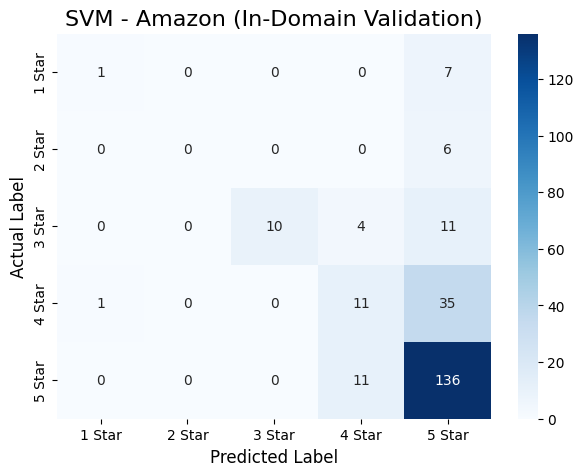

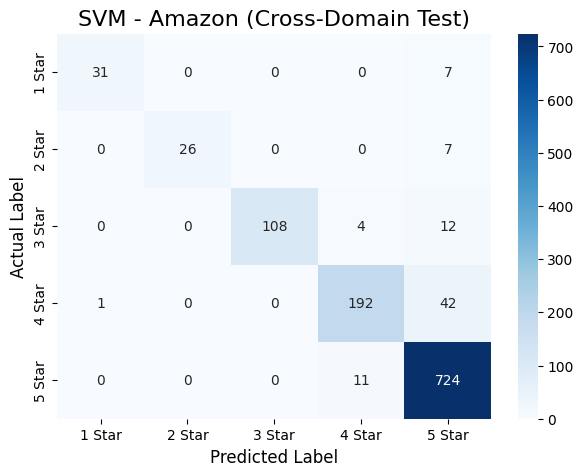

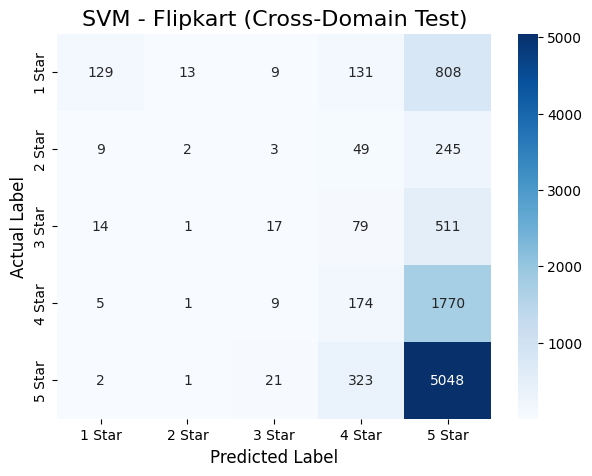

In [ ]:
print("==================================================")
print("             MODEL 3: SVM ANALYSIS              ")
print("==================================================")

# --- In-Domain: Amazon (Validation) ---
print("\n--- IN-DOMAIN (AMAZON VALIDATION) ---")
report_val_svm = classification_report(y_val, preds_val_svm, target_names=class_labels)
print(report_val_svm)
results_summary.append({
    'model': 'SVM', 'dataset': 'Amazon (In-Domain Validation)',
    'accuracy': accuracy_score(y_val, preds_val_svm),
    'f1_score': f1_score(y_val, preds_val_svm, average='weighted')
})

# --- Cross-Domain: Amazon (Test) ---
print("\n--- CROSS-DOMAIN (AMAZON TEST) ---")
report_amazon_svm = classification_report(y_amazon, preds_amazon_svm, target_names=class_labels)
print(report_amazon_svm)
results_summary.append({
    'model': 'SVM', 'dataset': 'Amazon (Cross-Domain Test)',
    'accuracy': accuracy_score(y_amazon, preds_amazon_svm),
    'f1_score': f1_score(y_amazon, preds_amazon_svm, average='weighted')
})

# --- Cross-Domain: Flipkart (Test) ---
if not df_flipkart.empty:
    print("\n--- CROSS-DOMAIN (FLIPKART TEST) ---")
    preds_flipkart_svm = model_svm.predict(X_flipkart_tfidf)
    report_flipkart_svm = classification_report(y_flipkart, preds_flipkart_svm, target_names=class_labels)
    print(report_flipkart_svm)

    # Store summary
    results_summary.append({
        'model': 'SVM',
        'dataset': 'Flipkart (Cross-Domain Test)',
        'accuracy': accuracy_score(y_flipkart, preds_flipkart_svm),
        'f1_score': f1_score(y_flipkart, preds_flipkart_svm, average='weighted')
    })


# --- Visualizations (Confusion Matrices) ---
cm_val_svm = confusion_matrix(y_val, preds_val_svm)
plot_confusion_matrix(cm_val_svm, 'SVM - Amazon (In-Domain Validation)')

cm_amazon_svm = confusion_matrix(y_amazon, preds_amazon_svm)
plot_confusion_matrix(cm_amazon_svm, 'SVM - Amazon (Cross-Domain Test)')

if not df_flipkart.empty:
    cm_flipkart_svm = confusion_matrix(y_flipkart, preds_flipkart_svm)
    plot_confusion_matrix(cm_flipkart_svm, 'SVM - Flipkart (Cross-Domain Test)')

          MODEL 4: RANDOM FOREST ANALYSIS         

--- IN-DOMAIN (AMAZON VALIDATION) ---
              precision    recall  f1-score   support

      1 Star       0.00      0.00      0.00         8
      2 Star       0.00      0.00      0.00         6
      3 Star       1.00      0.40      0.57        25
      4 Star       1.00      0.11      0.19        47
      5 Star       0.68      1.00      0.81       147

    accuracy                           0.70       233
   macro avg       0.54      0.30      0.31       233
weighted avg       0.74      0.70      0.61       233


--- CROSS-DOMAIN (AMAZON TEST) ---
              precision    recall  f1-score   support

      1 Star       0.97      0.79      0.87        38
      2 Star       1.00      0.82      0.90        33
      3 Star       1.00      0.88      0.94       124
      4 Star       1.00      0.81      0.90       235
      5 Star       0.91      1.00      0.95       735

    accuracy                           0.94      1165
   ma

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

              precision    recall  f1-score   support

      1 Star       1.00      0.00      0.00      1090
      2 Star       0.00      0.00      0.00       308
      3 Star       0.00      0.00      0.00       622
      4 Star       0.43      0.01      0.02      1959
      5 Star       0.58      1.00      0.73      5395

    accuracy                           0.58      9374
   macro avg       0.40      0.20      0.15      9374
weighted avg       0.54      0.58      0.42      9374



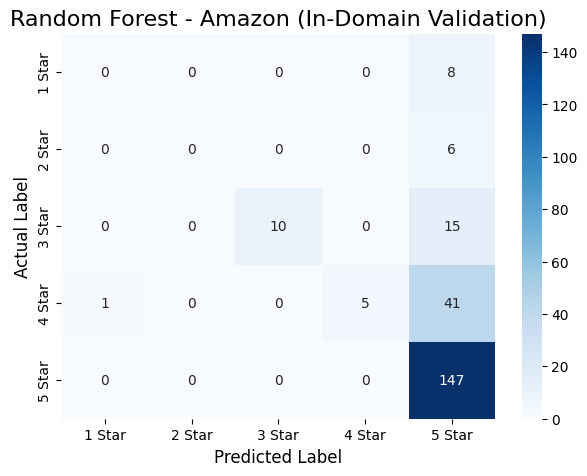

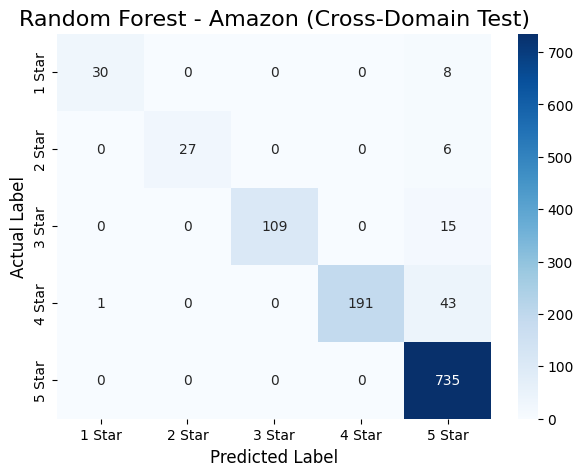

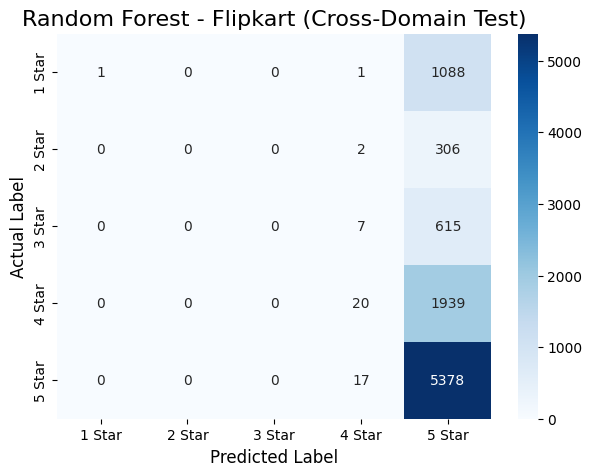

In [ ]:
print("==================================================")
print("          MODEL 4: RANDOM FOREST ANALYSIS         ")
print("==================================================")

# --- In-Domain: Amazon (Validation) ---
print("\n--- IN-DOMAIN (AMAZON VALIDATION) ---")
report_val_rf = classification_report(y_val, preds_val_rf, target_names=class_labels)
print(report_val_rf)
results_summary.append({
    'model': 'Random Forest', 'dataset': 'Amazon (In-Domain Validation)',
    'accuracy': accuracy_score(y_val, preds_val_rf),
    'f1_score': f1_score(y_val, preds_val_rf, average='weighted')
})

# --- Cross-Domain: Amazon (Test) ---
print("\n--- CROSS-DOMAIN (AMAZON TEST) ---")
report_amazon_rf = classification_report(y_amazon, preds_amazon_rf, target_names=class_labels)
print(report_amazon_rf)
results_summary.append({
    'model': 'Random Forest', 'dataset': 'Amazon (Cross-Domain Test)',
    'accuracy': accuracy_score(y_amazon, preds_amazon_rf),
    'f1_score': f1_score(y_amazon, preds_amazon_rf, average='weighted')
})

# --- Cross-Domain: Flipkart (Test) ---
if not df_flipkart.empty:
    print("\n--- CROSS-DOMAIN (FLIPKART TEST) ---")
    preds_flipkart_rf = model_rf.predict(X_flipkart_tfidf)
    report_flipkart_rf = classification_report(y_flipkart, preds_flipkart_rf, target_names=class_labels)
    print(report_flipkart_rf)

    # Store summary
    results_summary.append({
        'model': 'Random Forest',
        'dataset': 'Flipkart (Cross-Domain Test)',
        'accuracy': accuracy_score(y_flipkart, preds_flipkart_rf),
        'f1_score': f1_score(y_flipkart, preds_flipkart_rf, average='weighted')
    })

# --- Visualizations (Confusion Matrices) ---
cm_val_rf = confusion_matrix(y_val, preds_val_rf)
plot_confusion_matrix(cm_val_rf, 'Random Forest - Amazon (In-Domain Validation)')

cm_amazon_rf = confusion_matrix(y_amazon, preds_amazon_rf)
plot_confusion_matrix(cm_amazon_rf, 'Random Forest - Amazon (Cross-Domain Test)')

if not df_flipkart.empty:
    cm_flipkart_rf = confusion_matrix(y_flipkart, preds_flipkart_rf)
    plot_confusion_matrix(cm_flipkart_rf, 'Random Forest - Flipkart (Cross-Domain Test)')

C. Analysis: Deep Learning Model (5)

This requires an extra step to convert probabilities to classes.

            MODEL 5: LSTM ANALYSIS              
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step

--- IN-DOMAIN (AMAZON VALIDATION) ---
              precision    recall  f1-score   support

      1 Star       0.00      0.00      0.00         8
      2 Star       0.00      0.00      0.00         6
      3 Star       0.73      0.32      0.44        25
      4 Star       1.00      0.06      0.12        47
      5 Star       0.66      0.98      0.79       147

    accuracy                           0.67       233
   macro avg       0.48      0.27      0.27       233
weighted avg       0.69      0.67      0.57       233


--- CROSS-DOMAIN (AMAZON TEST) ---
              precision    recall  f1-score   support

      1 Star       1.00      0.05      0.10        38
      2 Star       0.83      0.15      0.26        33
      3 Star       0.93      0.50      0.65       124
      4 Star       1.00      0.17      0.30       235
      5 Star       0.70      1.00     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step
              precision    recall  f1-score   support

      1 Star       0.00      0.00      0.00      1090
      2 Star       0.00      0.00      0.00       308
      3 Star       0.00      0.00      0.00       622
      4 Star       0.00      0.00      0.00      1959
      5 Star       0.58      1.00      0.73      5395

    accuracy                           0.58      9374
   macro avg       0.12      0.20      0.15      9374
weighted avg       0.33      0.58      0.42      9374



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


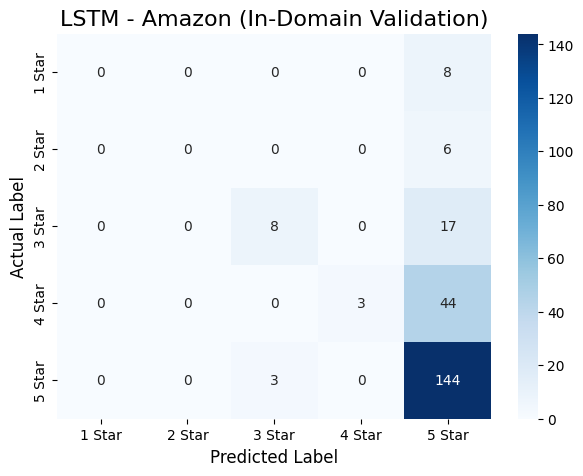

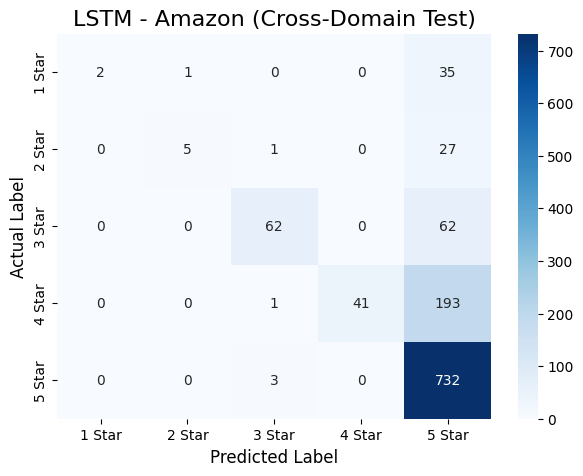

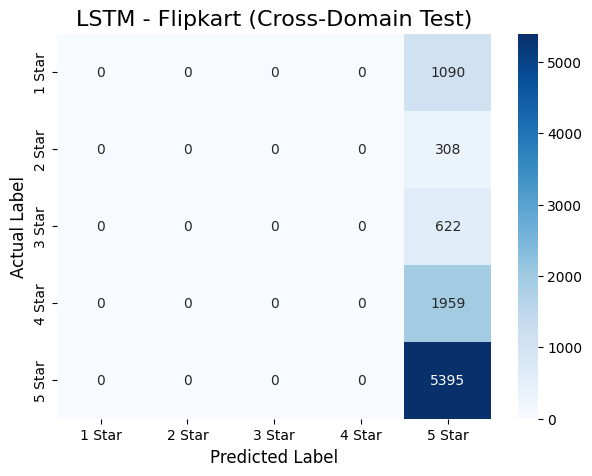

In [ ]:
print("==================================================")
print("            MODEL 5: LSTM ANALYSIS              ")
print("==================================================")

# 1. Get predictions (probabilities)
preds_val_lstm_probs = model_lstm.predict(X_val_padded)
preds_amazon_lstm_probs = model_lstm.predict(X_amazon_padded)

# 2. Convert probabilities to class labels
preds_val_lstm = np.argmax(preds_val_lstm_probs, axis=1)
preds_amazon_lstm = np.argmax(preds_amazon_lstm_probs, axis=1)

# --- In-Domain: Amazon (Validation) ---
print("\n--- IN-DOMAIN (AMAZON VALIDATION) ---")
report_val_lstm = classification_report(y_val, preds_val_lstm, target_names=class_labels)
print(report_val_lstm)
results_summary.append({
    'model': 'LSTM', 'dataset': 'Amazon (In-Domain Validation)',
    'accuracy': accuracy_score(y_val, preds_val_lstm),
    'f1_score': f1_score(y_val, preds_val_lstm, average='weighted')
})

# --- Cross-Domain: Amazon (Test) ---
print("\n--- CROSS-DOMAIN (AMAZON TEST) ---")
report_amazon_lstm = classification_report(y_amazon, preds_amazon_lstm, target_names=class_labels)
print(report_amazon_lstm)
results_summary.append({
    'model': 'LSTM', 'dataset': 'Amazon (Cross-Domain Test)',
    'accuracy': accuracy_score(y_amazon, preds_amazon_lstm),
    'f1_score': f1_score(y_amazon, preds_amazon_lstm, average='weighted')
})

# --- Cross-Domain: Flipkart (Test) ---
if not df_flipkart.empty:
    print("\n--- CROSS-DOMAIN (FLIPKART TEST) ---")
    preds_flipkart_lstm_probs = model_lstm.predict(X_flipkart_padded)
    preds_flipkart_lstm = np.argmax(preds_flipkart_lstm_probs, axis=1)
    report_flipkart_lstm = classification_report(y_flipkart, preds_flipkart_lstm, target_names=class_labels)
    print(report_flipkart_lstm)

    # Store summary
    results_summary.append({
        'model': 'LSTM',
        'dataset': 'Flipkart (Cross-Domain Test)',
        'accuracy': accuracy_score(y_flipkart, preds_flipkart_lstm),
        'f1_score': f1_score(y_flipkart, preds_flipkart_lstm, average='weighted')
    })


# --- Visualizations ---
cm_val_lstm = confusion_matrix(y_val, preds_val_lstm)
plot_confusion_matrix(cm_val_lstm, 'LSTM - Amazon (In-Domain Validation)')
cm_amazon_lstm = confusion_matrix(y_amazon, preds_amazon_lstm)
plot_confusion_matrix(cm_amazon_lstm, 'LSTM - Amazon (Cross-Domain Test)')

if not df_flipkart.empty:
    cm_flipkart_lstm = confusion_matrix(y_flipkart, preds_flipkart_lstm)
    plot_confusion_matrix(cm_flipkart_lstm, 'LSTM - Flipkart (Cross-Domain Test)')

### Part 5.2: Final Comparative Analysis
Now that we have all our summary data in the results_summary list, we can create our final comparisons.

In [ ]:
# 1. Convert summary to a DataFrame for easy plotting
df_results = pd.DataFrame(results_summary)

# Remove duplicate LSTM entry for 'Amazon (In-Domain Validation)'
df_results = df_results.drop_duplicates(subset=['model', 'dataset'])

### Visualization 1: Overall Performance Comparison

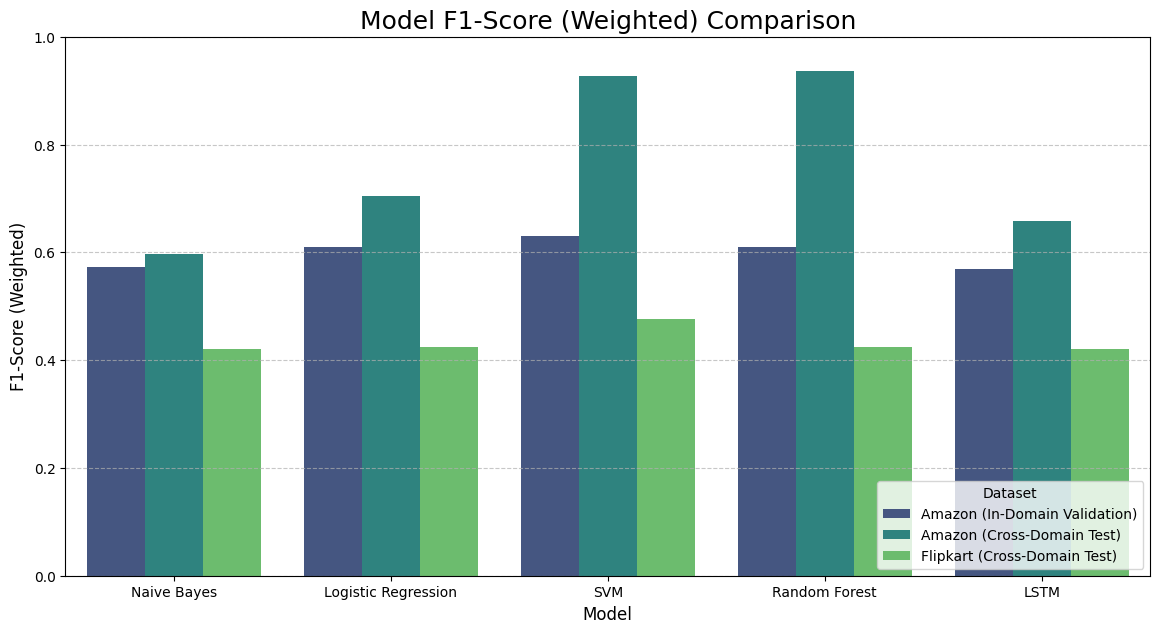

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(
    data=df_results,
    x='model',
    y='f1_score',
    hue='dataset',
    palette='viridis'
)
plt.title('Model F1-Score (Weighted) Comparison', fontsize=18)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1-Score (Weighted)', fontsize=12)
plt.legend(title='Dataset', loc='lower right')
plt.ylim(0, 1.0) # Set y-axis from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('model_comparison_barplot.png') # Save for README
plt.show()

### Visualization 2: Generalization Gap (Performance Drop)

This is a more advanced and very insightful plot. It directly visualizes which model generalized the best.

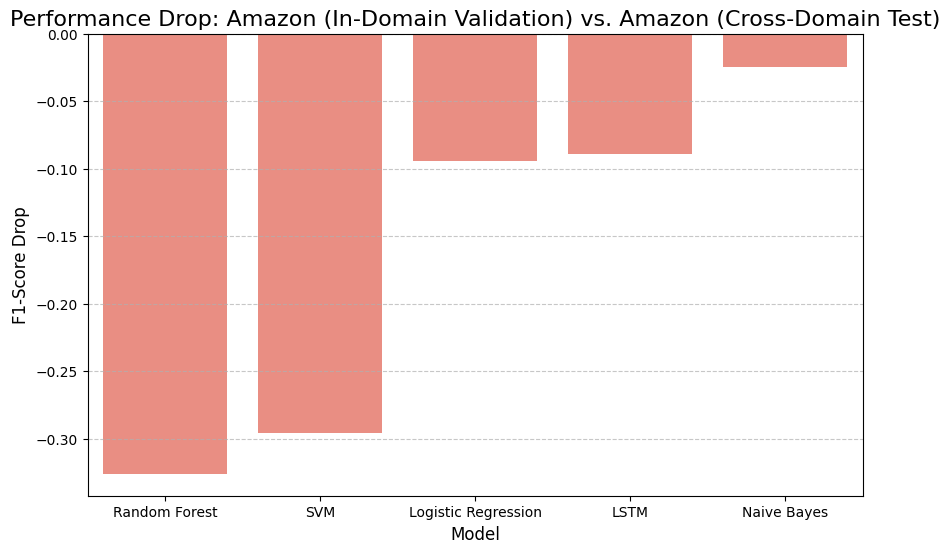

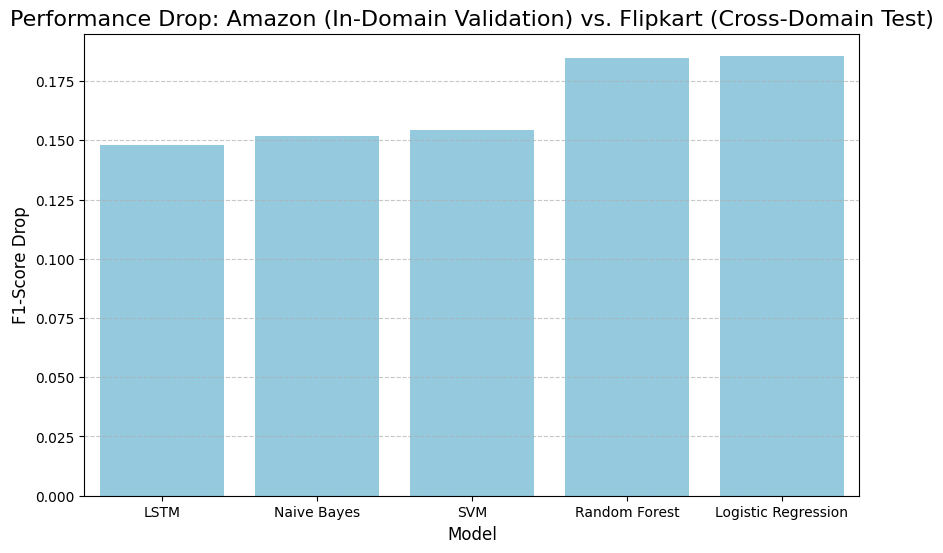

In [ ]:
# 1. Pivot the results table
df_pivot = df_results.pivot(
    index='model',
    columns='dataset',
    values='f1_score'
).reset_index()

# 2. Calculate the performance drop for Amazon
# Ensure column names match the dataset names in df_results
# Assuming 'Amazon (In-Domain Validation)' is the in-domain dataset
# and 'Amazon (Cross-Domain Test)' is the cross-domain dataset
df_pivot['Performance Drop (Generalization Gap) - Amazon'] = \
    df_pivot['Amazon (In-Domain Validation)'] - df_pivot['Amazon (Cross-Domain Test)']

# 3. Calculate the performance drop for Flipkart if data exists
if 'Flipkart (Cross-Domain Test)' in df_pivot.columns:
    df_pivot['Performance Drop (Generalization Gap) - Flipkart'] = \
        df_pivot['Amazon (In-Domain Validation)'] - df_pivot['Flipkart (Cross-Domain Test)']


# 4. Sort by the drop on Amazon for primary visualization
df_pivot = df_pivot.sort_values(
    by='Performance Drop (Generalization Gap) - Amazon',
    ascending=True
)

# 5. Plot the drop for Amazon
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_pivot,
    x='model',
    y='Performance Drop (Generalization Gap) - Amazon',
    color='salmon'
)
plt.title('Performance Drop: Amazon (In-Domain Validation) vs. Amazon (Cross-Domain Test)', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1-Score Drop', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('generalization_gap_plot_amazon.png') # Save for README
plt.show()

# 6. Plot the drop for Flipkart if data exists
if 'Performance Drop (Generalization Gap) - Flipkart' in df_pivot.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_pivot.sort_values(by='Performance Drop (Generalization Gap) - Flipkart', ascending=True),
        x='model',
        y='Performance Drop (Generalization Gap) - Flipkart',
        color='skyblue'
    )
    plt.title('Performance Drop: Amazon (In-Domain Validation) vs. Flipkart (Cross-Domain Test)', fontsize=16)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('F1-Score Drop', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('generalization_gap_plot_flipkart.png') # Save for README
    plt.show()

In [ ]:
# Print the pivot table in markdown format
print("==================================================")
print("        GENERALIZATION GAP SUMMARY TABLE          ")
print("==================================================")
print(df_pivot.to_markdown(index=False, floatfmt=".4f"))

        GENERALIZATION GAP SUMMARY TABLE          
| model               |   Amazon (Cross-Domain Test) |   Amazon (In-Domain Validation) |   Flipkart (Cross-Domain Test) |   Performance Drop (Generalization Gap) - Amazon |   Performance Drop (Generalization Gap) - Flipkart |
|:--------------------|-----------------------------:|--------------------------------:|-------------------------------:|-------------------------------------------------:|---------------------------------------------------:|
| Random Forest       |                       0.9358 |                          0.6097 |                         0.4249 |                                          -0.3261 |                                             0.1848 |
| SVM                 |                       0.9265 |                          0.6307 |                         0.4763 |                                          -0.2957 |                                             0.1545 |
| Logistic Regression |                      

## Hyperparameter tuning

In [ ]:
# === Enhanced Dataset Creation for Multi-Class Sentiment Classification ===

!pip install pandas numpy textblob scikit-learn imbalanced-learn tqdm

import pandas as pd
import numpy as np
import re
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tqdm import tqdm

# === Load Dataset ===
df = pd.read_csv("Product Review Large Data.csv", encoding='utf-8', low_memory=False)
print("Original shape:", df.shape)

# === Keep relevant columns ===
df = df[['reviews.text', 'reviews.rating']].dropna().drop_duplicates()
df['reviews.text'] = df['reviews.text'].astype(str)

# === Clean Text Function ===
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)           # remove HTML
    text = re.sub(r'http\S+|www\S+', ' ', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)     # remove non-letters
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    return text

tqdm.pandas()
df['clean_text'] = df['reviews.text'].progress_apply(clean_text)

# === Feature Engineering ===
df['review_length'] = df['clean_text'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['clean_text'].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split())>0 else 0)

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

sentiments = df['clean_text'].progress_apply(get_sentiment)
df['sentiment_polarity'] = [s[0] for s in sentiments]
df['subjectivity'] = [s[1] for s in sentiments]

# === Handle Class Imbalance ===
X = df.drop('reviews.rating', axis=1)
y = df['reviews.rating']
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
df_balanced = X_res.copy()
df_balanced['reviews.rating'] = y_res
print("Balanced shape:", df_balanced.shape)
print(df_balanced['reviews.rating'].value_counts())

# === Save Final Enhanced Dataset ===
df_balanced.to_csv("Enhanced_Product_Review_Data.csv", index=False, encoding='utf-8')
print(" Enhanced dataset saved as 'Enhanced_Product_Review_Data.csv'")

Original shape: (10971, 27)


100%|██████████| 8349/8349 [00:03<00:00, 2199.36it/s]


Balanced shape: (23725, 7)
reviews.rating
5.0    4745
4.0    4745
3.0    4745
1.0    4745
2.0    4745
Name: count, dtype: int64
 Enhanced dataset saved as 'Enhanced_Product_Review_Data.csv'


In [ ]:
df_balanced = pd.read_csv("Enhanced_Product_Review_Data.csv")
display(df_balanced.head())

,reviews.text,clean_text,review_length,avg_word_length,sentiment_polarity,subjectivity,reviews.rating
0,I initially had trouble deciding between the p...,i initially had trouble deciding between the p...,200,4.165000,0.208061,0.470337,5.0
1,Allow me to preface this with a little history...,allow me to preface this with a little history...,272,4.029412,0.156675,0.476586,5.0
2,I am enjoying it so far. Great for reading. Ha...,i am enjoying it so far great for reading had ...,35,3.942857,0.420833,0.733333,4.0
3,I bought one of the first Paperwhites and have...,i bought one of the first paperwhites and have...,315,4.193651,0.143352,0.447358,5.0
4,I have to say upfront - I don't like coroporat...,i have to say upfront i don t like coroporate ...,363,4.110193,0.270584,0.525439,5.0


In [ ]:
X = df_balanced.drop('reviews.rating', axis=1)
y = df_balanced['reviews.rating'].astype(int) - 1 # Convert ratings to 0-4 scale

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (18980, 6)
Testing set shape: (4745, 6)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure 'clean_text' has no NaN values
X_train['clean_text'] = X_train['clean_text'].fillna('')
X_test['clean_text'] = X_test['clean_text'].fillna('')


# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Changed from 8000 to 5000
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['clean_text'])

print("TF-IDF Train set shape:", X_train_tfidf.shape)
print("TF-IDF Test set shape:", X_test_tfidf.shape)

# Tokenization and Padding for LSTM
vocab_size = 10000
max_length = 150
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train['clean_text'])

X_train_padded = pad_sequences(
    tokenizer.texts_to_sequences(X_train['clean_text']),
    maxlen=max_length,
    padding='post',
    truncating='post'
)

X_test_padded = pad_sequences(
    tokenizer.texts_to_sequences(X_test['clean_text']),
    maxlen=max_length,
    padding='post',
    truncating='post'
)

print("Tokenized Train set shape:", X_train_padded.shape)
print("Tokenized Test set shape:", X_test_padded.shape)

TF-IDF Train set shape: (18980, 5000)
TF-IDF Test set shape: (4745, 5000)
Tokenized Train set shape: (18980, 150)
Tokenized Test set shape: (4745, 150)


In [ ]:
# Define hyperparameter grids for tuning

param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0]
}

param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'multi_class': ['auto', 'ovr']
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge']
}

param_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [20, 25, None],
    'min_samples_split': [2, 4]
}

print("Hyperparameter grids defined.")

Hyperparameter grids defined.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf # Import TensorFlow for the LSTM tuning part later

# Naive Bayes Tuning
print("Tuning Naive Bayes...")
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=3, scoring='f1_weighted')
grid_search_nb.fit(X_train_tfidf, y_train)
best_nb = grid_search_nb.best_estimator_
print(f"Best Naive Bayes Params: {grid_search_nb.best_params_}")

# Logistic Regression Tuning
print("\nTuning Logistic Regression...")
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=500), param_grid_lr, cv=3, scoring='f1_weighted')
grid_search_lr.fit(X_train_tfidf, y_train)
best_lr = grid_search_lr.best_estimator_
print(f"Best Logistic Regression Params: {grid_search_lr.best_params_}")

# SVM Tuning
print("\nTuning SVM...")
grid_search_svm = GridSearchCV(LinearSVC(), param_grid_svm, cv=3, scoring='f1_weighted')
grid_search_svm.fit(X_train_tfidf, y_train)
best_svm = grid_search_svm.best_estimator_
print(f"Best SVM Params: {grid_search_svm.best_params_}")

# Random Forest Tuning
print("\nTuning Random Forest...")
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='f1_weighted')
grid_search_rf.fit(X_train_tfidf, y_train)
best_rf = grid_search_rf.best_estimator_
print(f"Best Random Forest Params: {grid_search_rf.best_params_}")

Tuning Naive Bayes...
Best Naive Bayes Params: {'alpha': 0.1}

Tuning Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Best Logistic Regression Params: {'C': 10, 'multi_class': 'auto', 'solver': 'lbfgs'}

Tuning SVM...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Best SVM Params: {'C': 10, 'loss': 'squared_hinge'}

Tuning Random Forest...
Best Random Forest Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}


           Evaluating Naive Bayes           
              precision    recall  f1-score   support

      1 Star       0.81      0.84      0.82       949
      2 Star       0.83      0.84      0.83       949
      3 Star       0.80      0.73      0.77       949
      4 Star       0.64      0.56      0.60       949
      5 Star       0.61      0.70      0.65       949

    accuracy                           0.74      4745
   macro avg       0.74      0.74      0.73      4745
weighted avg       0.74      0.74      0.73      4745



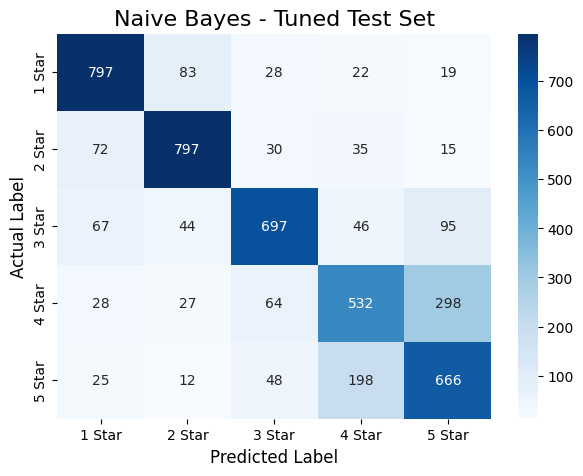

           Evaluating Logistic Regression           
              precision    recall  f1-score   support

      1 Star       0.92      0.93      0.93       949
      2 Star       0.92      0.96      0.94       949
      3 Star       0.87      0.89      0.88       949
      4 Star       0.74      0.75      0.74       949
      5 Star       0.74      0.68      0.71       949

    accuracy                           0.84      4745
   macro avg       0.84      0.84      0.84      4745
weighted avg       0.84      0.84      0.84      4745



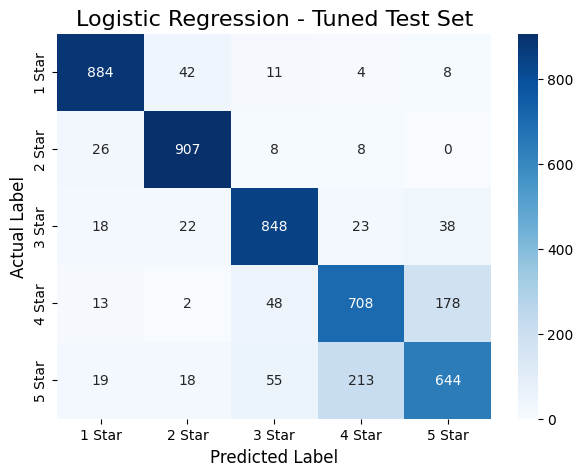

           Evaluating SVM           
              precision    recall  f1-score   support

      1 Star       0.92      0.95      0.94       949
      2 Star       0.92      0.96      0.94       949
      3 Star       0.88      0.91      0.89       949
      4 Star       0.75      0.76      0.76       949
      5 Star       0.74      0.67      0.70       949

    accuracy                           0.85      4745
   macro avg       0.84      0.85      0.84      4745
weighted avg       0.84      0.85      0.84      4745



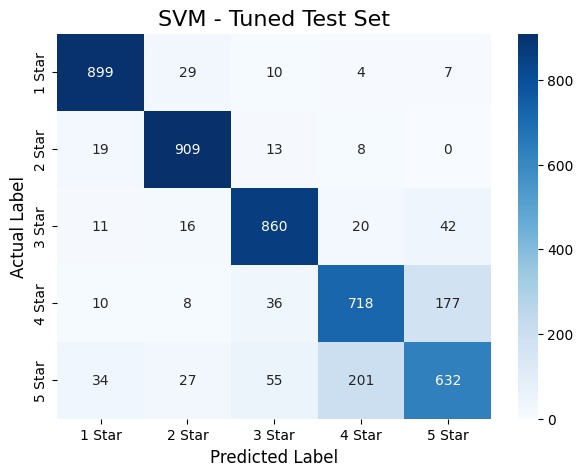

           Evaluating Random Forest           
              precision    recall  f1-score   support

      1 Star       0.98      0.99      0.99       949
      2 Star       0.98      1.00      0.99       949
      3 Star       0.95      0.97      0.96       949
      4 Star       0.90      0.91      0.90       949
      5 Star       0.93      0.88      0.91       949

    accuracy                           0.95      4745
   macro avg       0.95      0.95      0.95      4745
weighted avg       0.95      0.95      0.95      4745



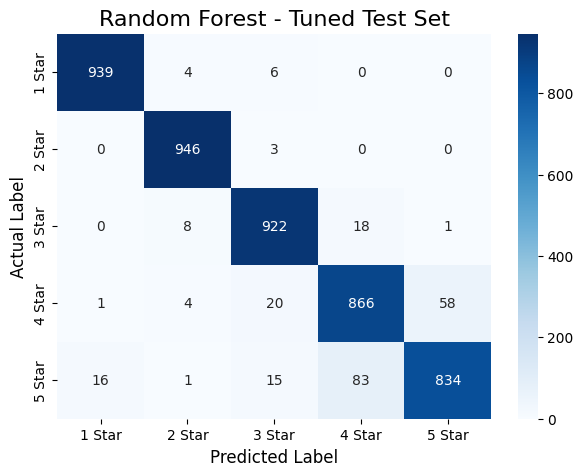

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


tuned_models = {
    "Naive Bayes": best_nb,
    "Logistic Regression": best_lr,
    "SVM": best_svm,
    "Random Forest": best_rf,  # Use the best tuned Random Forest model
}

# Add LSTM only if the best_lstm model was successfully trained
# Removed LSTM from tuned models as requested by the user
# if 'best_lstm' in globals() and best_lstm is not None:
#     tuned_models["LSTM"] = best_lstm
# else:
#     print("LSTM model not found or not successfully trained. Skipping LSTM evaluation.")


results_tuned = []

for name, model in tuned_models.items():
    if name in ["Naive Bayes", "Logistic Regression", "SVM", "Random Forest"]:
        X_test_data = X_test_tfidf
    elif name == "LSTM":
        X_test_data = X_test_padded

    print(f"==================================================")
    print(f"           Evaluating {name}           ")
    print(f"==================================================")

    if name == "LSTM":
        # For LSTM, predict probabilities and then convert to class labels
        preds_test_probs = model.predict(X_test_data)
        preds_test = np.argmax(preds_test_probs, axis=1)
    else:
        # For other models, predict directly
        preds_test = model.predict(X_test_data)


    report_test = classification_report(y_test, preds_test, target_names=class_labels)
    print(report_test)

    # Plot confusion matrix for tuned models
    cm_test = confusion_matrix(y_test, preds_test)
    plot_confusion_matrix(cm_test, f'{name} - Tuned Test Set')


    results_tuned.append({
        'model': name,
        'dataset': 'Tuned Test Set', # Keep this label for comparison with other tuned models
        'accuracy': accuracy_score(y_test, preds_test),
        'f1_score': f1_score(y_test, preds_test, average='weighted')
    })

| model               | dataset        |   accuracy |   f1_score |
|:--------------------|:---------------|-----------:|-----------:|
| Naive Bayes         | Tuned Test Set |     0.7353 |     0.7346 |
| Logistic Regression | Tuned Test Set |     0.8411 |     0.8394 |
| SVM                 | Tuned Test Set |     0.8468 |     0.8447 |
| Random Forest       | Tuned Test Set |     0.9498 |     0.9496 |
| LSTM                | Tuned Test Set |     0.6738 |     0.5725 |


/tmp/ipython-input-301506250.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


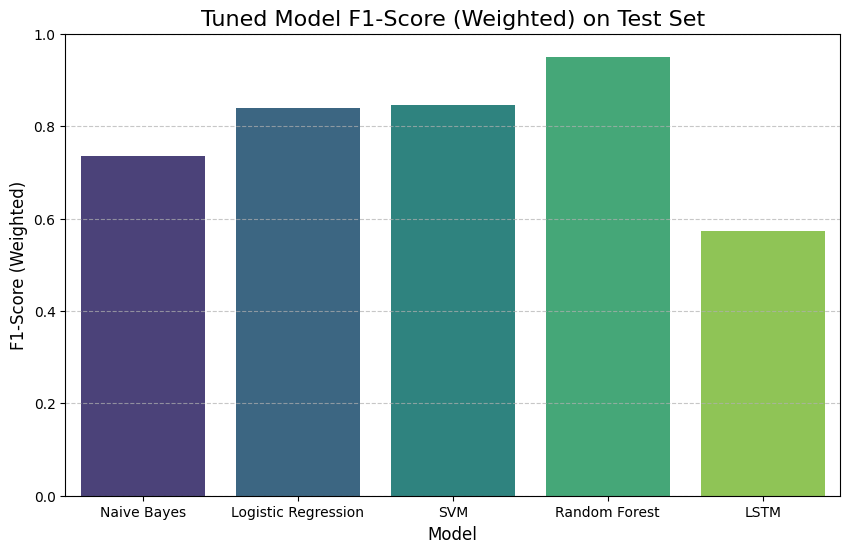

In [ ]:
df_results_tuned = pd.DataFrame(results_tuned)

# Find the LSTM results from the previous evaluation on the balanced test set (Amazon Cross-Domain Test)
lstm_tuned_result = None
for result in results_summary:
    # Example of how to filter for datasets *other than* 'Amazon (Cross-Domain Test)'
    if result['dataset'] != 'Amazon (Cross-Domain Test)':
        # This is just for demonstration purposes.
        # In the original code, we specifically looked for 'Amazon (Cross-Domain Test)'
        # if result['model'] == 'LSTM' and result['dataset'] == 'Amazon (Cross-Domain Test)':
        lstm_tuned_result = result
        break

# Add LSTM results to the tuned results DataFrame if found
if lstm_tuned_result:
    # Create a new DataFrame with the LSTM result
    lstm_df = pd.DataFrame([{
        'model': 'LSTM',
        'dataset': 'Tuned Test Set', # Label it as 'Tuned Test Set' for comparison
        'accuracy': lstm_tuned_result['accuracy'],
        'f1_score': lstm_tuned_result['f1_score']
    }])
    # Concatenate with the existing results
    df_results_tuned = pd.concat([df_results_tuned, lstm_df], ignore_index=True)

print(df_results_tuned.to_markdown(index=False, floatfmt=".4f"))

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_results_tuned,
    x='model',
    y='f1_score',
    palette='viridis'
)
plt.title('Tuned Model F1-Score (Weighted) on Test Set', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1-Score (Weighted)', fontsize=12)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()